<a href="https://colab.research.google.com/github/TheArmbreaker/Object-Detection-Air-Base-Military-Equipment/blob/mil_equipment/B2Spirit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5 - Anwendungsbeispiel

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14566, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 14566 (delta 84), reused 116 (delta 71), pack-reused 14430
Receiving objects: 100% (14566/14566), 13.50 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (10061/10061), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd yolov5
%pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 1.6 MB 33.9 MB/s 


In [4]:
import torch
from IPython.display import Image
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.preprocessing.image import load_img

In [5]:
for i in [("/content/drive/MyDrive/Exkurs_B2Spirit/stealth_bomber.yaml","/content/yolov5/data/stealth_bomber.yaml"),("/content/drive/MyDrive/Exkurs_B2Spirit/hyp.stealth_bomber.yaml","/content/yolov5/data/hyps/hyp.stealth_bomber.yaml")]:
  src_file = i[0]
  dst_file = i[1]
  shutil.copy(src_file, dst_file)

## Vorbemerkung

Bilder von intakten Militärgerät sind i.d.R. schwer zu beschaffen, weshalb die Datensätze für professionelle Use-Cases oft mit Bildern von 3D-Modellen angereichert werden. Aktuell wird zum Beispiel daran gearbeitet mit Object Detection verschiedene Kampfpanzer-Modelle zu unterscheiden und nicht nur die Typen, wie beispielsweise Schützen- von Kampfpanzern. {cite:p}`EST`

Der in der Introduction angekündigte Zufallsfund von Tarnkappenbombern des Typs B2 Spirit, welche auf einer US Airbase in Hawaii stationiert sind, wird verwenden um diese Situtation nachzubilden und anhand dieses simplifizierte Umfangs die Arbeitsweise mit Yolov5 und die Metriken zu erklären. Das Vorgehen und die Erkenntnisse aus dem einfachen Modell werden im Anschluss auf den eigentlichen UseCase, die Erkennungen von Flugobjekten auf Militärebasen, angewendet. 

## Datenbeschaffung

### Aufnahme von Trainingsbildern 

Die vorliegenden Screenshots und wenige andere Internetfunde sind nicht ausreichend, um das Erkennen des Tarnkappenbombers zu trainieren. Das oben erwähnte Modellieren von 3D-Modellen war zeitlich nicht umsetzbar. Stattdessen werden Bilder von einem 3D-gedruckten Modell verwendet. Die Internetfunde werden als Anwendugnsdatein genutzt. 

Die Bilder von dem 3D-gedruckten Modell weisen folgende Merkmale auf: 

* Grau lackiertes Modell ähnlich zum Orginal
* Aufnahme in notwendiger Vogel-/Satellitenperspektive
* Unterschiedliche Hintergründe (hell und dunkel)
* Hinzufügen von lackierten Dreiecken als Hintergrundbilder für eine bessere Abstraktion
* Beliebige Anzahl an Hintergrundbildern ohne Objekt
* Aufnahmen mit unterschiedlicher Beleuchtung (Innenraum)
* Aufnahmen zu unterschiedlicher Tageszeit (Außenbereich)
* Nutzung von Schatten als Wolkenersatz

```{figure} nb_images/mil_equip/Modell_B2.jpg
---
name: Modell_B2
---
Eigene Darstellung: Modell B2
```


### Datenerzeugung

Es gibt verschiedene Methoden zur Datenanreicherung. Diese sind teilweise in YOLOv5 integriert und werden als Hyperparameter für das Training mitgegeben. Die dafür notwendige Hyperparameter-YAML-Datei wurde wie folgt angepasst.

* Image Rotation um +/- 90 Grad
* Skalierung um +/- 0.5
* Wahrscheinlichkeit für Spiegelung Oben/Unten: 0.5
* Wahrscheinlichkeit für Spiegelung Links/Rechts: 0.5
* Wahrscheinlichkeit für Erzeugen eines Mosaics: 1.0
* Wahrscheinlichkeit für Erzeugen eines MixUp: 0.5

Folgende Abbildung von ultralytics erläutert die Funktionsweise der **Mosaik-Erzeugung**. Aus einem Bild werden mehrere Bilder erzeugt und das Mosaic für das Trainig verwendet.

```{figure} nb_images/mil_equip/ultralytics_image_augmentation.jpeg
---
name: imgAugment
---
Image Augmentation in YOLOv5 {cite:p}`YOLOv5_Issue1921`
```

Der **MixUp** beschreibt die Überlagerung von mehreren Bildern. Dies wird im folgenden Bildausschnitt aus dem selbst erzeugten Trainingsdatensatz verdeutlicht. Es handelt sich um eine Datei, welche von YOLOv5 beim Trainingsstart erzeugt und abgelegt wird. Die beschriebene Überlagerung ist im mittleren Bildabschnitt besonders gut dargestellt. In der linken oberen Ecke wird ein Flugzeugbild aus dem DOTA-Datensatz abgebildet.

```{figure} nb_images/mil_equip/beispiel_train_mixup.jpg
---
name: ExampleMixUp
---
Eigene Darstellung: MixUp aus Trainingsdurchlauf
```


## Training 

### Modell 1

Ein Basismodell wird trainiert in dem die `train.py`-Datei mit verschiedenen Paramtern im Terminal (siehe auch Erläuterung zum Working Directory) aufgerufen werden. 
Zur Bestimmung eines Basis-Modells müssen folgende 5 Parameter verändert:
* data
* weights
* img
* epoch
* batch

Mit dem Parameter --data wird die .yaml-Datei angegeben, welche für das Training herangezogen wird. In dieser Datei sind die Pfade zu den Trainings- und Validierungsdaten angegeben, wie auch die zu prognostizierenden Klassenbezeichnungen und ihre Nummer.

In [ ]:
#TODO Richtiges YAML eintragen 
import re
start = 0
with open("C:\dev\yolov5\data\stealth_bomber.yaml") as f:
    for lines in f: 
        if (re.match("^path", lines)):
            start = 1
        if (start == 1):
            print(lines)

Durch `--weights` können dem Modell vorgelernte Gewichte mitgeben werden. Die verschiedene Modelle werden in der *YOLOv5 Erläuterung* vorgestellt. Für Modell 1 wird das S-Modell gewählt. Dieses wird über den `weights`-Parameter als .pt-Datei aufgerufen. Mit dem Parameter `--img` wird die Größe der Input-Bilder in Pixel vorgegeben und die Bilder entsprechend skaliert. Im Fall vom Modell 1 sind es 640 Pixel. Die Anzahl an Epochen bestimmt wie oft das neuronale Netz mit den gesamten Trainingsdaten trainiert wird. Der Wert wird über den Parameter `--epochs` definiert. Mit `--batch` wird die Anzahl der gemeinsam gelernten Bilder definiert. Dies wird durch die Rechenleistung der Hardware limitiert. Durch den Parameter `batch -1` wird die für die Hardware optimale Batchsize automatisch ermittelt. Gemäß des nachfolgenden Trainingsoutputs wurde dies auf 157 Bilder festgelegt. Dies ist insbesondere interessant, da nur 84 Trainingsbildern zur Verfügung gestellt wurden.Die Ursache für die hohe Bildanzahl könnte die oben erläuterte Datenanreicherung sein. 

Zur Vereinfachung der Arbeit werden mit `project` und `name` die Results unter eigenen Dateipfaden abgespeichert. Mit dem Parameter `cache` werden die Daten in den Arbeitsspeicher geladen. 

Über die Basisparamter hinaus werden für das Modell 1 noch die Parameter `freeze` und `hyp` verwendet. Mit dem Parameter `freeze 10` wird der Backbone des S-Modells (siehe YOLOv5 Erläuterung) eingefroren und nur die Gewichte im Head trainiert. Dies reduziert die Laufzeit und bietet sich wegen der mangelnden Datenlage an. Die im YOlOV5 Erläuterung angesprochene Hyperparameter-YAML-Datei verwendet standardmäßig folgende wesentlichen Hyperparameter (keine vollständige Liste):
* LR0 = 0.01
* LRF = 0.01
* Weight Decay = 0.0005
* IoU Threshold = 0.2 (geändert auf 0.5, für bessere Confidence bei wenig Daten)

In [ ]:
!python train.py --project /content/drive/MyDrive/Exkurs_B2Spirit/colab_exports --name No2_S_Train --freeze 10 --hyp data/hyps/hyp.stealth_bomber.yaml --weights yolov5s.pt --epochs 500 --batch -1 --img 640 --data stealth_bomber.yaml --cache

train: weights=yolov5s.pt, cfg=, data=stealth_bomber.yaml, hyp=data/hyps/hyp.stealth_bomber.yaml, epochs=500, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports, name=No2_S_Train, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-216-g6e544d5 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.5, a

Das Training wurde nach 279 Epochen abgebrochen, weil seit Epoche 178 keine Verbesserungen gemessen wurden.

### Modell 2

Im Modell 2 werden die besten Gewichte des zuvor trainierten Modell 1 weiter trainiert. Dafür wird der `weights`-Parameter mit der gespeicherten best.pt-Datei aufgerufen. 
Das Training erfolgt mit einer anderen, von YOLO mitgelieferten, Hyperparameter-YAML-Datei, welche geringere Learning Rates und Weight-Decays verwendet. Dadurch kann das zuvor erreichte Minimum der Loss Function weiter reduziert werden.

TODO Loss Funtion 

* LR0 = 0.01 --> 0.00334
* LRF = 0.01 --> 0.15135
* Weight Decay = 0.005 --> 0.00025

Die weiter oben erläuterten Hyperparameter wie etwa Mosaic oder Mixup werden auf dem Standardwert dieser YAML-Datei belassen.

Des weiteren wird der oben erläuterte Backbone nicht eingefroren, also das gesamte Netz trainiert. Das Training erfolgt über 300 Epochen. Das ist ein Standardwert, weshalb der Parameter nicht übergeben werden muss. Gleiches gilt für die Batchsize 16.

In [ ]:
!python train.py --hyp '/content/yolov5/data/hyps/hyp.VOC.yaml' --project /content/drive/MyDrive/Exkurs_B2Spirit/colab_exports --name No2_S_FineTuning --weights '/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt' --img 640 --data stealth_bomber.yaml --cache

train: weights=/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt, cfg=, data=stealth_bomber.yaml, hyp=/content/yolov5/data/hyps/hyp.VOC.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports, name=No2_S_FineTuning, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-216-g6e544d5 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.00334, lrf=0.15135, momentum=0.74832, weight_decay=0.00025, warmup_epochs=3.3835, warmup_momentu

## Validation

### Metriken

Nachfolgend werden die Trainingsmetriken dargestellt. Dabei ist zubeachten, dass der Train-Test-Split nicht optimal ist und die Ergebnisse der Validation entsprechend hinterfragt werden müssten. Anhand der beiden Modelle sollen die Metriken und ihre Wechselwirkungen erklärt werden. 

In den folgenden Darstellungen werden je nach Trainings- und Validationsdaten die Metriken für box_loss (Bounding Box Regression Loss), obj_loss (Objectness Loss) und class_loss  (Classification Loss) abgebildet. Die Metriken Precision, Recall, mAP50 und mAP50:95 haben einen großen Einfluss auf die Confusion Matrix und werden im nachfolgenden Abschnitt genauer erläutert. 

Der Box Loss kann als Mean Squared Error interpretiert werden {cite:p}`YOLOv5_penguins`.  
Darunter wird der Grad der Unterscheidung zwischen der so genannten Groundtruth (siehe nachfolgenden Abschnitt) und der predicted Bounding Box verstanden. Umso geringer der Error, desto besser trifft die Prediction auf die Groundtruht zu. {cite:p}`bbox_loss`

Der Objectness Loss beschreibt die binary cross-entropy. Ein geringerer Loss Wert beschreibt eine hohe Konfidenz zum Vorhandensein eines Objekts. Der Classification Loss dient zur Unterscheidung zwischen den trainierten Objekten. Der class_loss ist Null, weil in dem Beispiel nur ein Label für den B2 Spirit trainiert wurde. Desto geringer dieser Loss, umso besser ist die Unterscheidung zwischen Objekten. {cite:p}`YOLOv5_penguins`

Modell 2 zeigt hinsichtlich box_loss (MSE) und obj_loss (binary cross-entropy) eine deutliche Verbesserung. Precision, Recall und mAP werden ebenfalls deutlich besser und weniger sprunghaft.

```{figure} nb_images/mil_equip/grundmodell_results.png
---
name: Results_B2_M1
---
Eigene Darstellung: Results Modell 1
```
```{figure} nb_images/mil_equip/tunedmodell_results.png
---
name: Results_B2_M2
---
Eigene Darstellung: Results Modell 2
```


### Confusion Matrix

#### Theorie und Praxis

Nachfolgend werden die zwei Confusion Matrixen für Modell 1 und Modell 2 abgebildet. Die Matrixen sind das Resultat einer automatischen Validierung am Ende des Trainings. Es wird gezeigt, dass das Modell 1 bei der Unterscheidungen zwischen Tarnkappenbomber und Hintergrund (Dreiecke aus Papier, andere Flugzeuge oder tatsächlicher Boden) eine hohe Unsicherheit hat. Für das Modell 2 ergibt sich diese Unsicherheit nicht mehr. Auffällig ist, dass der Background weiterhin nicht als Background klassifiziert wird. Der Grund dafür ist, dass im Kontext von Object Detection die Matrixen anders interpretiert werden müssen. 

Für die Zuordnung von True Positive, False Positive, True Negative und False Negativ verwendet die Object Detection die Intersection over Union (IoU), welche maximiert wird. Die Überlappung von Groundtruth und Predicted Box im Verhältnis zur gemeinsamen Fläche ergeben den IoU. Die Groundtruth meint die für das Training bereitgestellte Bounding Box eines gelabelten Objekts. Die predicted Box stellt die Prediction des Modells dar. {cite:p}`cm_objdect`

D.h. IoU verhält sich invers zum oben erwähnten Box Loss.

$ IoU = {area of overlap\over area  of  union} $

Abhängig von einem bestimmten Grad der Überlappung (Threshold) werden die Predictions zugeordnet nach:

* True Positive
* False Positive
* True Negative (nur für Objektklassen gültig)
* False Negative 

In einer Confusion Matrix für Mulit-Class Klassifikation ergeben sich die True Negatives als Summe aller Zellen, welche für die Predicted Class irrelavant sind {cite:p}`cm_multiclass`.  
Für den Hintergrund bei Object Detection ist dies nicht zutreffend, weil der Hintergrund nicht gelabelt ist. D.h. für False Negative Background wird die Groundtruth nicht erkannt und bei False Positve Background wird ein Objekt ohne Groundtruth (also ein nicht vorhandenes Objekt) erkannt. Daraus ergibt sich, dass die Precision gegen alle Detections (TP+FP) prüft und Recall gegen alle Groundtruths (TP+FN). {cite:p}`cm_objdect`

Im Fall von YOLOv5 gibt es einen weiteren Sonderfall. Die angezeigten Werte sind auf den Recall normiert und für bessere Interpretation wurden die Zeile und die Spalte für FP Background und FN Background vertauscht. Dies ist eine deutliche Abweichung von üblichen Klassifikationmatrixen. D.h. abweichend von einer üblichen Klassifikationsmatrix verlaufen die False Positive Predictions parallel zur Predicted-Achse. {cite:p}`YOLOv5_Issue2701`


```{figure} nb_images/mil_equip/grundmodell_confusion_matrix.png
---
name: cm_m1
scale: 75%
---
Eigene Darstellung: Confusion Matrix Modell 1
```

```{figure} nb_images/mil_equip/tunedmodell_confusion_matrix.png
---
name: cm_m2
scale: 75%
---
Eigene Darstellung: Confusion Matrix Modell 2
```


#### Einfluss des Konfidenzwerts

Einen entscheidenen Einfluss auf die Metriken hat auch der Konfidenzwert. Unter der Konfidenz ist die Wahrscheinlichkeit des Objekt-Vorhandenseins zu verstehen.  
Bei der Validierung wird der Konfidenz-Defaultwert von 0.001 verwendet. Dies vervollständigt den Inhalt der Confusion Matrix, da alle FP und FN Werte einfließen. Jedoch ist ein so geringer Konfidenzwert nicht zielführend bei der späteren Inference (Anwendung des Modells).  
Durch Erhöhen des Konfidenzwerts werden True Positive und False Positive Werte aussortiert und damit Precision und Recall verändert. Dieser Trade-Off zwischen Precision und Recall kann positive und negative Auswirkungen haben.

In [1]:
!python val.py  --conf 0.9 --weights /content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt --project /content/drive/MyDrive/Exkurs_B2Spirit/colab_exports --name No2_S_Training_Validation_conf_09 --img 640 --data stealth_bomber.yaml 

python: can't open file 'C:\dev\Object-Detection-Air-Base-Military-Equipment\val.py': [Errno 2] No such file or directory


In [12]:
!python val.py  --conf 0.8 --weights /content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt --project /content/drive/MyDrive/Exkurs_B2Spirit/colab_exports --name No2_S_Training_Validation_conf_08 --img 640 --data stealth_bomber.yaml 

val: data=/content/yolov5/data/stealth_bomber.yaml, weights=['/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.8, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports, name=No2_S_Training_Validation_conf_05, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.8 > 0.001 produces invalid results
YOLOv5 🚀 v6.2-216-g6e544d5 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/drive/MyDrive/Exkurs_B2Spirit/labels/validation.cache' images and labels... 6 found, 4 missing, 0 empty, 0 corrupt: 100% 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   m

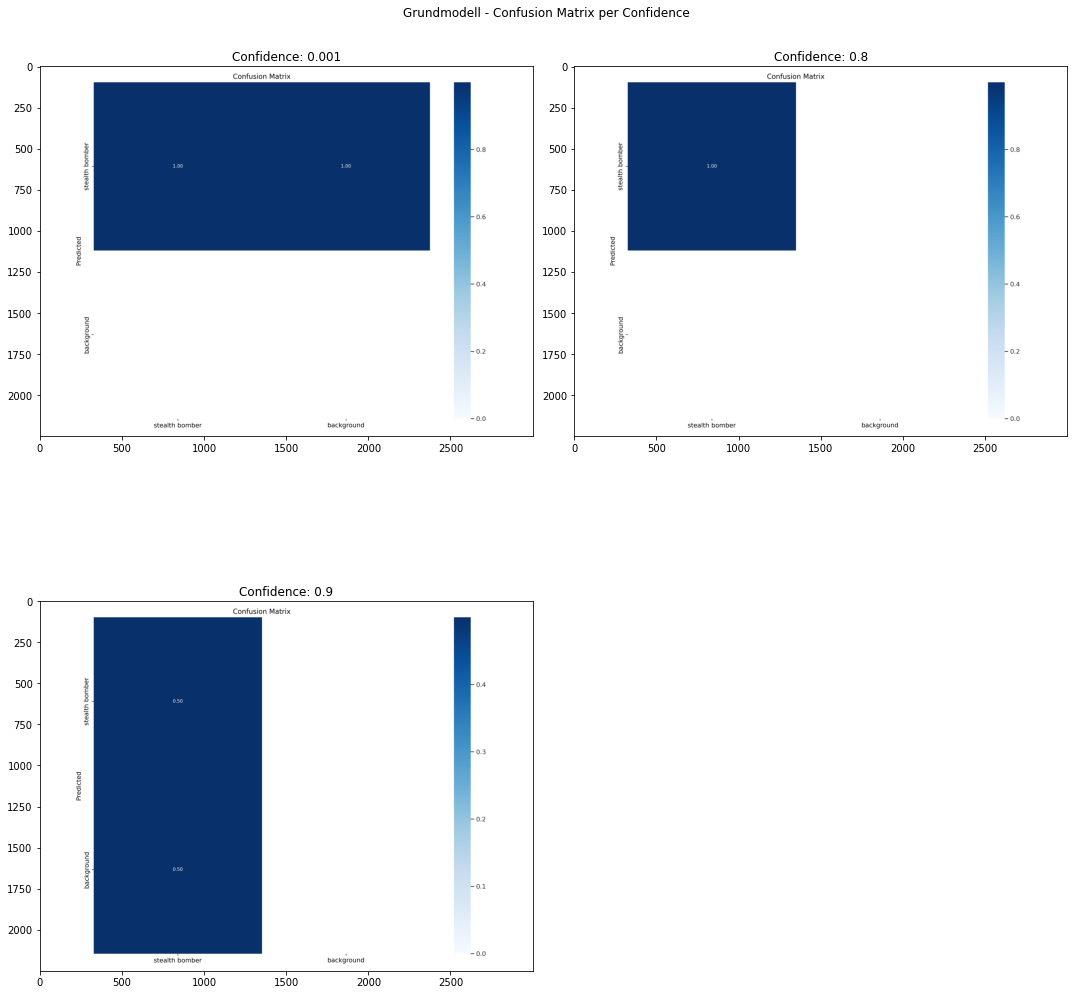

In [6]:
fig, (ax1,ax2) = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout()
plt.suptitle('Grundmodell - Confusion Matrix per Confidence')
ax1[0].imshow(load_img('/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/confusion_matrix.png'))
ax2[0].imshow(load_img('/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Training_Validation_conf_09/confusion_matrix.png'))
ax1[1].imshow(load_img('/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Training_Validation_conf_08/confusion_matrix.png'))
ax1[0].set_title('Confidence: 0.001')
ax1[1].set_title('Confidence: 0.8')
ax2[0].set_title('Confidence: 0.9')
ax2[1].remove()

```{glue:figure} boot_fig
:name: "cm_conf_plot"

Eigene Darstellung: Confusion Matrixen zu Konfidenzwert
```

In den Plots werden Confusion Matrizen des Modells dargestellt. Es wird gezeigt, dass die Steigerung des Konfidenzwert zu mehr False Negative führt. Ergänzend müssen die Modell-Outputs in den jeweiligen Zellen beachtet werden, welche nochmal tabellarisch abgebildet werden.


```{table} Precision und Recall bei Konfidenz-Anpassung
:name: conf_table

| Confidence  | 0.001  | 0.8  | 0.9  |
|---|---|---|---|
| Precision  | 0.871  | 1  | 1  |
| Recall  | 1  | 1  | 0.5  |

```

Beim Sprung von Confidence 0.001 auf 0.8 verändert sich der Recall nicht, stattdessen erhöht sich die Precision. D.h. es werden Predictions (TP sowie FP) unterhalb der 0.8 "aussortiert" - eine positive Auswirkung.
Beim Confidence Sprung von 0.8 auf 0.9 nimmt der Recall deutlich ab, es werden weitere True Positives aussortiert - eine negative Auswirkung. D.h. durch setzen eines höheren Konfidenzwerts können bei der Confusion Matrix die Ergebnisse des Modell 2 erreicht werden - ohne die zusätzlichen Tuning-Aktivitäten. Da vermeintliche Fehl-Klassifikation lediglich aussortiert wird ist es nicht zwingend die bessere Vorgehensweise.

Das bisher als Aussortieren bezeichnete Ereignis ist die Non-max suppression, welche auf das YOLOv5 Grid angewendet wird, um mehrfach Detektionen zu vermeiden. Dabei wird nur die höchste Wahrscheinlichkeit des Objekt-Vorhandenseins verwendet und weiter IoU-Werte ausgeblendet. Für mehrfache Objekte innerhalb einer Grid-Zelle wird dies je Anchorbox durchgeführt. Anchorboxen wurden bei der Erläuterung zu YOLOv5 beschrieben. {cite:p}`YOLOv5_masks`

Generell gilt, dass hohe Konfidenz-Grenzwert den Recall reduziert. Der sehr gute mAP-Wert des obigen Modells verursacht den Trade Off zwischen Precision und Recall erst im hohen Konfidenz-Bereich. Dieser Trade Off kann durch eine PR-Kurve visualisiert werden.

Das folgende Bild aus dem Github Repository zu YOLOv5 verdeutlicht den Zusammenhang zwischen Confidence, Precision und Recall. Zusätzlich wird der mAP als Fläche unter der PR-Kurve gezeigt.

mAP steht für mean Average Precision. Deste höher der Wert, umso besser ist das Modell. Dies wird im Anschluss über manuelle Veränderung des Konfidenzwerts vorgeführt. Die mean Average Precision ist der Durchschnitt aus den Average Precision Werten je Klasse bzw. Label. Es handelt sich um einen Trade-Off zwischen Precision und Recall.

Bzgl. der oben dargestellen Metrik-Grafiken steht die 0.5 in mAP0.5 für einen IoU Threshold von 50%. Der mAP0.5:0.95 beschreibt eine weitere Erhöhung des mAP bis zu 95% - in 5% Schritten.

```{figure} nb_images/mil_equip/pr_curve_threshold.png
---
name: pr_curve_example
---
Beispiel PR-Kurve und Konfidenz-Threshold von {cite:t}`YOLOv5_Issue4521`
```

## Modellanwendung / Inference

### Vorbereitung

Der Konfidenzwert hat auch einen Einfluss auf das Deployment. Für die Inference liegt der YOLOv5 Defaultwert für Confidence bei 0.25.

In den folgenden Codezellen werden zunächst die Modelle mit PyTorch geladen und ein Dictionary erstellt, welches die Resultate zu verschiedenen Internetfunden (Hickam Air Force Base und US Whiteman Air Force)und jeweils unterschiedlichen Zoom enthält.Mit dem Parameter *augment = True* wird das Eingabebild mit verschiedenen Anpassungen (bspw. Drehungen) untersucht. Dies verbessert die Erkennung auf Kosten der Laufzeit und ist daher nicht für alle Anwendungsfälle angebracht.


Am Ende des Fine Tunings mit kleineren Hyperparemetern zeigt sich eine Verbessung bei Precision und mAP50-95.

In [7]:
model_train = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt')
model_fine = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_FineTuning/weights/best.pt')

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
INFO:yolov5:YOLOv5 🚀 2022-10-30 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 2022-10-30 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla 

In [8]:
detect_files = [
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/stealthbomber_testbild_mittel.png',
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/stealthbomber_testbild_weit.png',
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/stealthbomber_fliegend_nah.jpg',
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/stealthbomber_fliegend_weit.jpg',
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/Hawaii_Tarnkappenbomber.png',
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/Hawaii_Tarnkappenbomber2.png',
    '/content/drive/MyDrive/Exkurs_B2Spirit/test_images/Hawaii_Tarnkappenbomber3.png',
    ]

In [9]:
train_results = dict()
tune_results = dict()
for i in detect_files:
  myKey = i.split('/')[-1].split('.')[0]
  train_results[myKey] = model_train(i,augment=True)
  tune_results[myKey] = model_fine(i,augment=True)

In [10]:
tune_results.keys()

dict_keys(['stealthbomber_testbild_mittel', 'stealthbomber_testbild_weit', 'stealthbomber_fliegend_nah', 'stealthbomber_fliegend_weit', 'Hawaii_Tarnkappenbomber', 'Hawaii_Tarnkappenbomber2', 'Hawaii_Tarnkappenbomber3'])

### Hickam Air Force Base - Beispiel I

#### Standard Confidence: 0.25

Im Folgenden die Anwendung auf eine hohe Zoomstufe mit dem Standard-Confidence-Wert von YOLOv5.

Das Grundmodell erkennt ein dreieckiges Feld als Tarnkappenbomber, aber nicht die drei tatsächlichen Tarnkappenbomber im Zentrum des Bildes. Ähnliches gilt für die darauf folgende Ausgabe für das verbesserte Modell. Hier wird jedoch, wie gemäß der Confusion Matrix zu erwarten, das dreieckige Feld nicht mit False Positiv (Type I Error) klassifiziert.

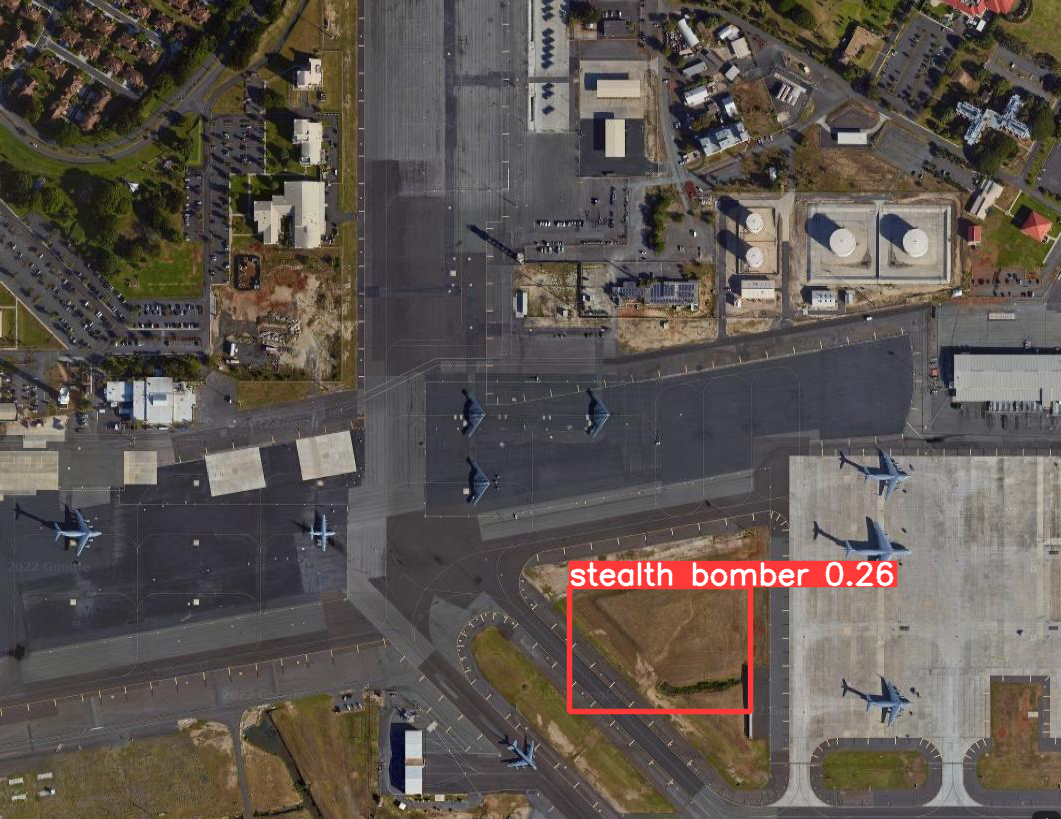

In [11]:
train_results['Hawaii_Tarnkappenbomber'].show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, U.S. Geological Survey, USGS

```{glue:figure} boot_fig2
:name: "output_m1_025"

Output zu Modell 1 mit Conf-Threshold 0.25 und weiten Zoom
```


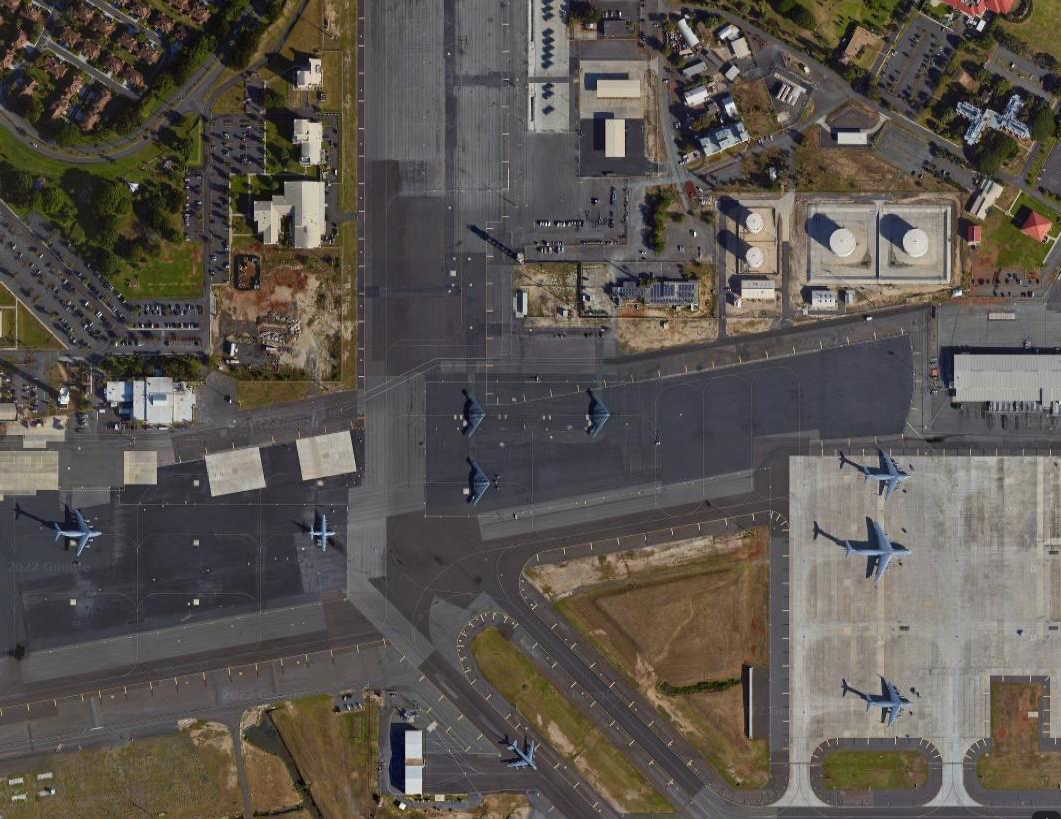

In [ ]:
tune_results['Hawaii_Tarnkappenbomber'].show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, U.S. Geological Survey, USGS
```{glue:figure} boot_fig3
:name: "output_m2_025"

Output zu Modell 2 mit Conf-Threshold 0.25 und weiten Zoom
```


#### Erhöhte Confidence: 0.27

Nachfolgend wird für das Grundmodell die Confidence auf 0.27 erhöht. Wodurch der Type I Error verschwindet.

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
INFO:yolov5:YOLOv5 🚀 2022-10-30 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 2022-10-30 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
INFO:yolov5:Adding AutoShape... 
Adding AutoShape... 


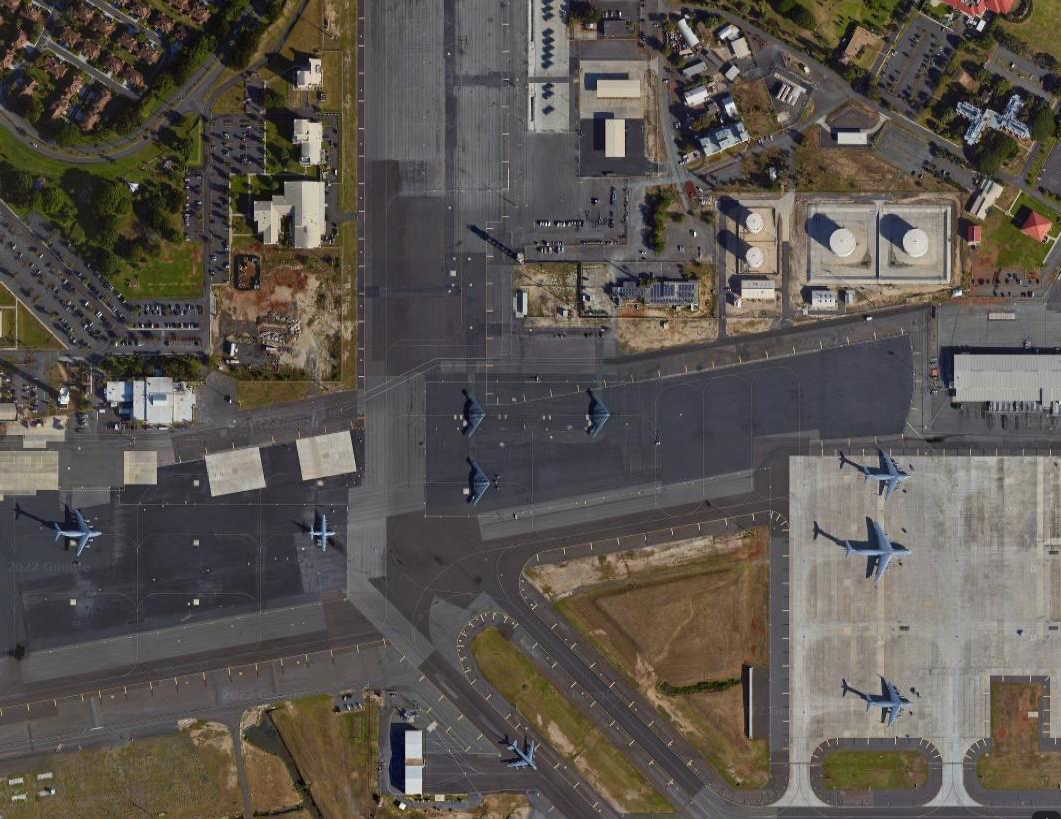

In [13]:
model_train2 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Exkurs_B2Spirit/colab_exports/No2_S_Train/weights/best.pt')
model_train2.conf = 0.27
results = model_train2('/content/drive/MyDrive/Exkurs_B2Spirit/test_images/Hawaii_Tarnkappenbomber.png', augment=True)
results.show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, U.S. Geological Survey, USGS

```{glue:figure} boot_fig4
:name: "output_m1_027"

Output zu Modell 1 mit Conf-Threshold 0.27 und weiten Zoom
```

### Hickam Air Force Base - Beispiel II

Abschließend ein Screenshot auf größerer Zoomstufe.

Das Grundmodell ist sich bei der Erkennung des Tarnkappenbombers wesentlich sicherer als das verbesserte Modell. Die Ursache für diesen Effekt im Zusammenhang mit dem oben gezeigten Type I Error liegt darin, dass das Grundmodell die grobe Dreiecksform des Tarnkappenbombers stärker zu berücksichtigen scheint als das verbesserte Modell.

Vor dem Hintergrund der geringen Anzahl an Trainingsdaten ist vorstellbar, dass eine deutliche Erhöhung dieser Anzahl

* die False-Positive-Rate des Grundmodells oder 
* die Confidence des verbesserten Modells für noch unterschiedlichere Flugfelder (Bildhintergrund)

verbessern könnte.

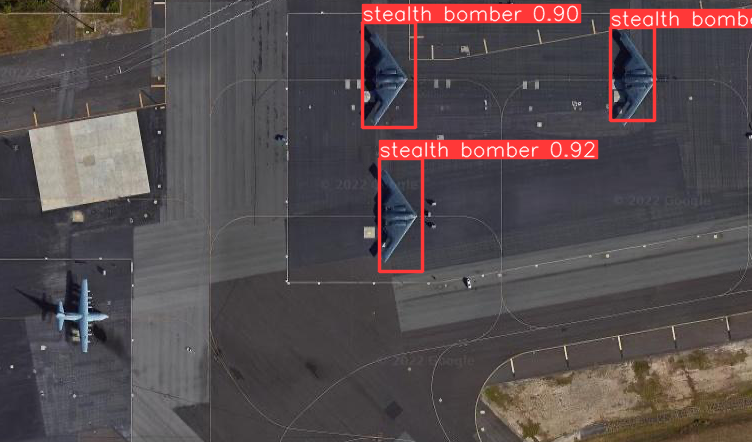

In [ ]:
train_results['Hawaii_Tarnkappenbomber2'].show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, U.S. Geological Survey, USGS


```{glue:figure} boot_fig5
:name: "output_m1_nah"

Output zu Modell 1 mit nahen Zoom
```


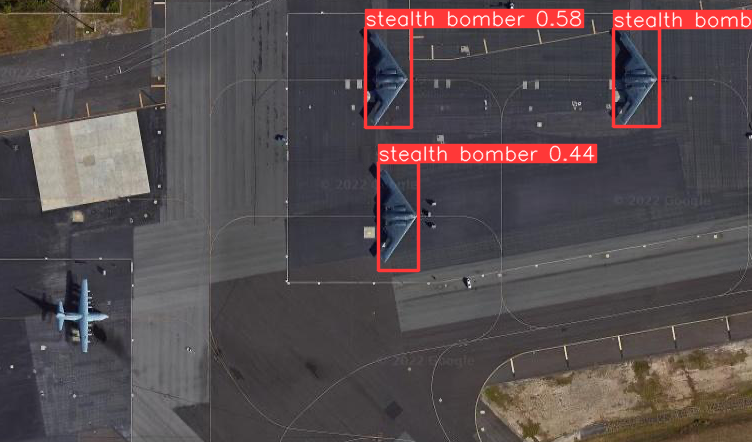

In [ ]:
tune_results['Hawaii_Tarnkappenbomber2'].show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, U.S. Geological Survey, USGS

```{glue:figure} boot_fig6
:name: "output_m2_nah"

Output zu Modell 2 mit nahen Zoom
```


### US Whiteman Air Force Base

Zur oberen Erläuterung passen auch die folgenden Ergebnisse bei der Anwendung auf eine vermeintliche Unfallstelle auf der Whitemen Air Force Base.

Das Grundmodell zeigt mehr Confidence für den Tarnkappenbomber, aber auch einen Type I Error für die Grünfläche.

Das verbesserte Modell zeigt weniger Confidence, dafür ohne Type I Error. Im Trainingsverlauf hat es keine Grünflächen in unmittelbarer Nähe des Flugzeugs kennengelernt.

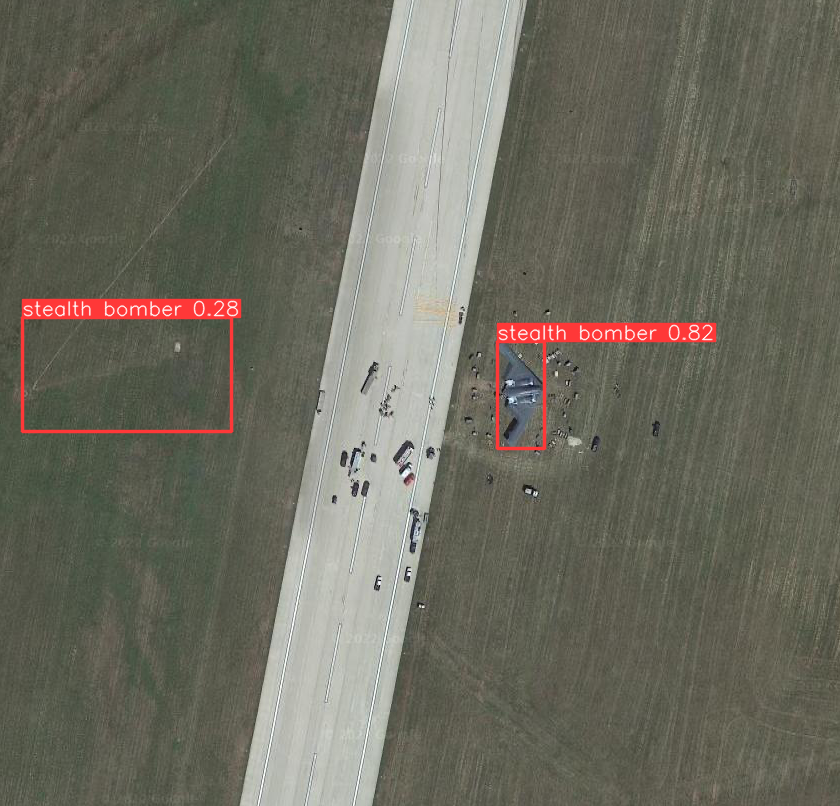

In [ ]:
train_results['stealthbomber_testbild_mittel'].show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies

```{glue:figure} boot_fig7
:name: "output_m1_whiteman"

Output zu Modell 1 - Whiteman
```

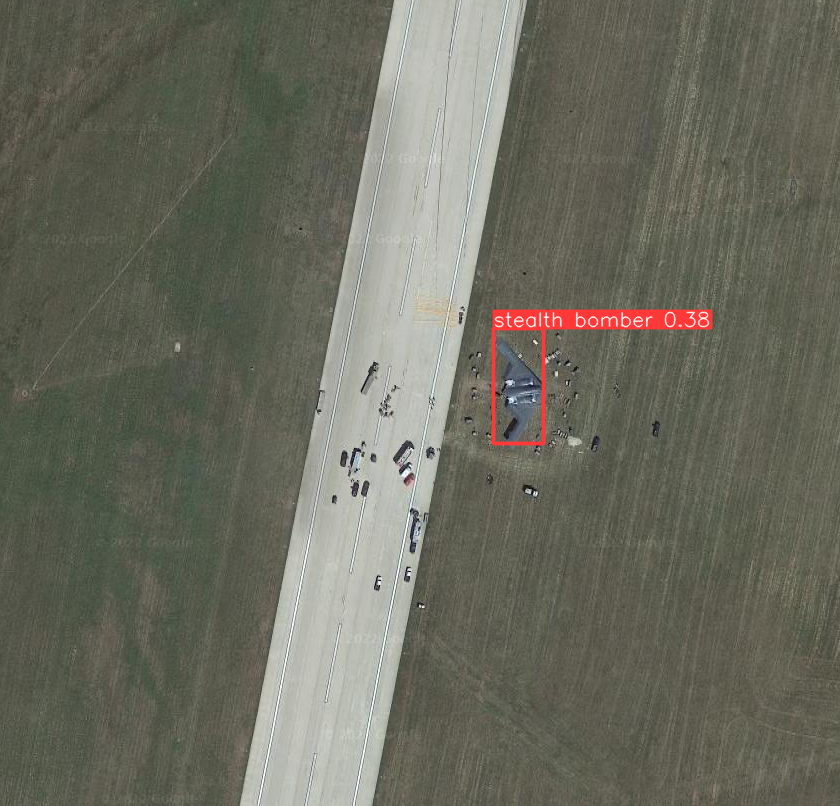

In [ ]:
tune_results['stealthbomber_testbild_mittel'].show()

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies


```{glue:figure} boot_fig8
:name: "output_m2_whiteman"

Output zu Modell 2 - Whiteman
```